In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from lib.nb_08b import *

We start with PIL transforms to resize all our images to the same size. Then, when they are in a batch, we can apply data augmentation to all of them at the same time on the GPU. We have already seen the basics of resizing and putting on the GPU in 08, but we'll look more into it now.

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [4]:
tfms

 <function lib.nb_04.to_byte_tensor(item)>,
 <function lib.nb_04.to_float_tensor(item)>]

In [5]:
# export
def get_il(path, tfms): return ImageList.from_files(path, tfms=tfms)

In [6]:
il = get_il(path, tfms)

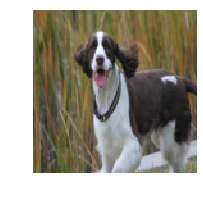

In [7]:
idx =4500
show_image(il[idx])

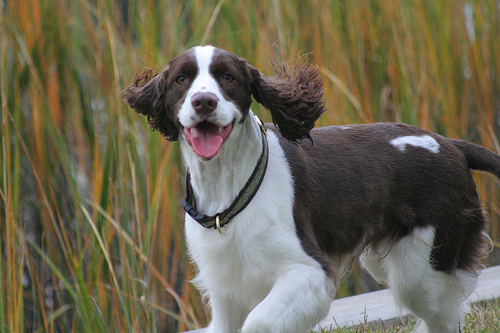

In [8]:
img = PIL.Image.open(il.items[idx])
img

In [9]:
%timeit -n 10 a = np.array(PIL.Image.open(il.items[idx]))

4.1 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


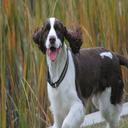

In [10]:
img.resize((128,128), resample=PIL.Image.ANTIALIAS)

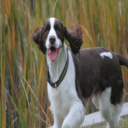

In [11]:
img.resize((128,128), resample=PIL.Image.BILINEAR)

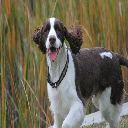

In [12]:
img.resize((128,128), resample=PIL.Image.NEAREST)

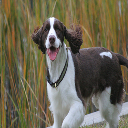

In [13]:
img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)

#### Flipping and Dihedral Rotations

**Flipping the image**

In [14]:
#export
import random

In [15]:
# export
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<0.5 else x

In [16]:
il1 = get_il(path, tfms)
il1.items = [il1.items[idx]]*64
dl = DataLoader(il1, 8)

In [17]:
x = next(iter(dl))

In [18]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)

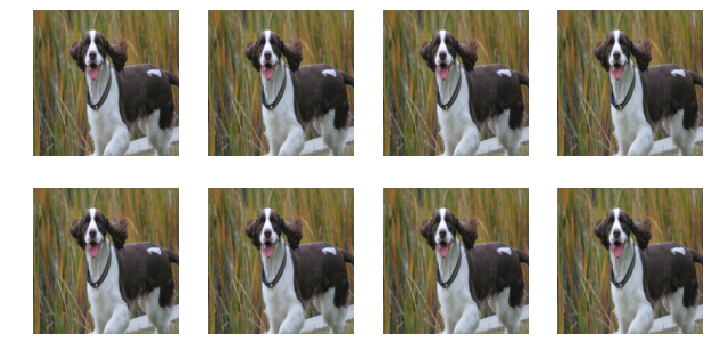

In [19]:
show_batch(x)

In [20]:
il1.tfms.append(pil_random_flip)

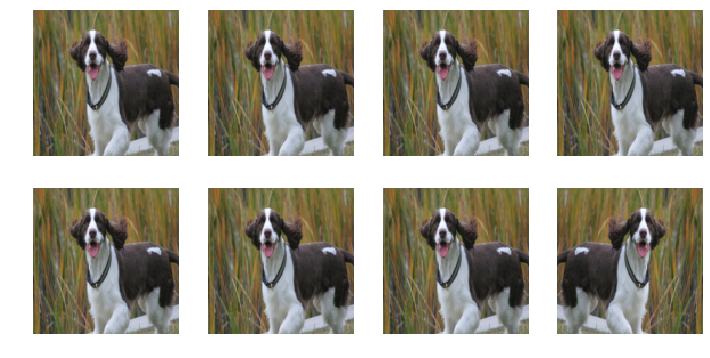

In [21]:
x = next(iter(dl))
show_batch(x)

In [22]:
#export
class PilTransform(Transform): _order=11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [23]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

In [24]:
il.tfms

 <function lib.nb_04.to_byte_tensor(item)>,
 <function lib.nb_04.to_float_tensor(item)>,

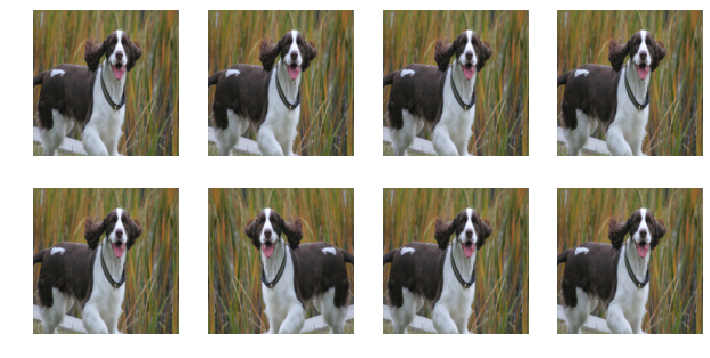

In [25]:
x = next(iter(dl))
show_batch(x)

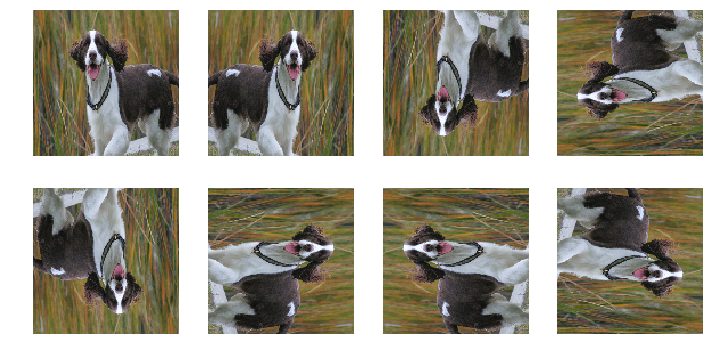

In [26]:
img = PIL.Image.open(il.items[idx])
img = img.resize((128,128), resample=PIL.Image.NEAREST)
_, axs = plt.subplots(2, 4, figsize=(12, 6))
for i,ax in enumerate(axs.flatten()):
    if i==0: ax.imshow(img)
    else:    ax.imshow(img.transpose(i-1))
    ax.axis('off')

In [27]:
#export
class PilRandomDihedral(PilTransform):
    def __init__(self, p=0.75): self.p=p*7/8 
        #Little hack to get the 1/8 identity dihedral transform taken into account.
    def __call__(self, x):
        if random.random()>self.p: return x
        return x.transpose(random.randint(0,6))

In [28]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomDihedral())

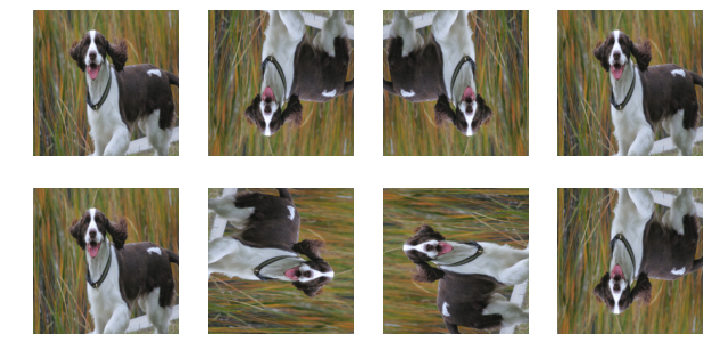

In [29]:
show_batch(next(iter(dl)))

This way we can acertain, in which `order` our transforms (*_note_ to self: this is usefull for callbacks as well.*) will be run. 
***

```python 
[(o._order,o) for o in sorted(tfms, key=operator.attrgetter('_order'))]
```

In [30]:
[(o._order,o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <lib.nb_04.MakeRGB at 0x1a283c29b0>),
 (10, <lib.nb_04.ResizeFixed at 0x1a283c2940>),
 (11, <__main__.PilRandomDihedral at 0x1a29faf358>),
 (20, <function lib.nb_04.to_byte_tensor(item)>),
 (30, <function lib.nb_04.to_float_tensor(item)>)]

In [31]:
#export
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

It is actually faster to combine to_float_tensor and to_byte_tensor in one transform using numpy.

In [32]:
%timeit -n 10 to_float_tensor(to_byte_tensor(img))

111 µs ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
%timeit -n 10 np_to_float(img)

148 µs ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Cropping

In [34]:
img = PIL.Image.open(il.items[0])
img.size

(1162, 773)

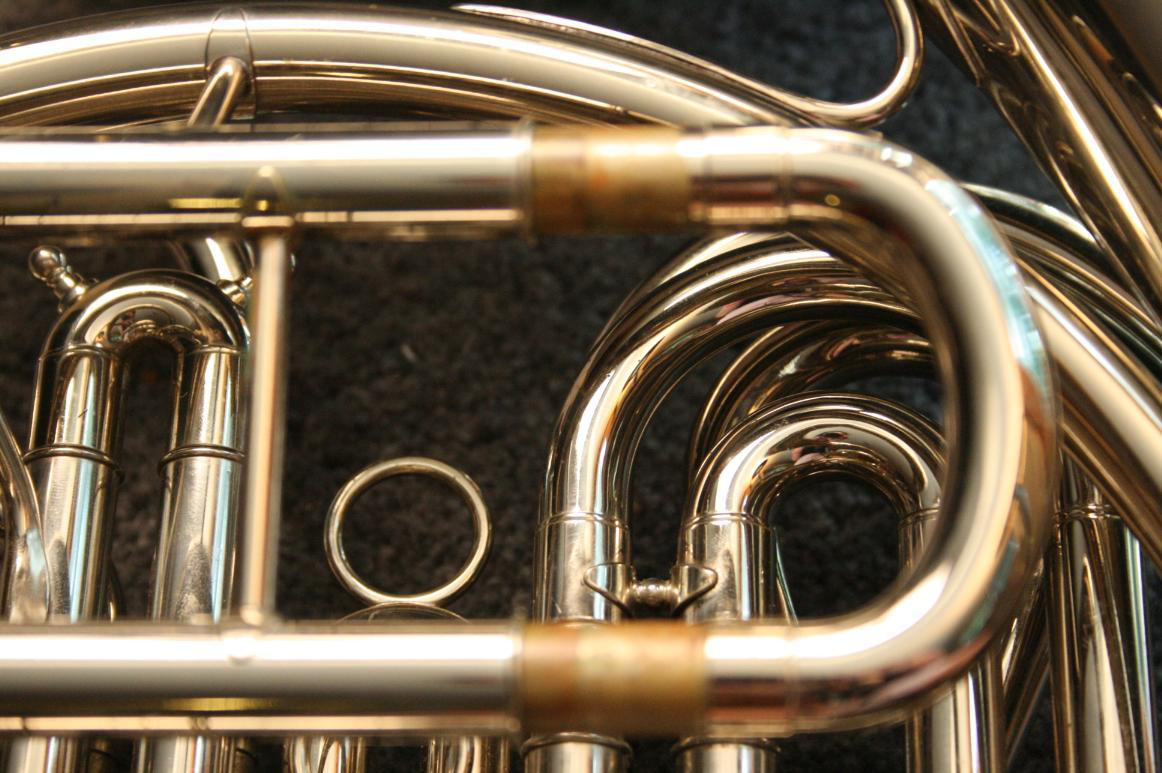

In [35]:
img

To crop an image with PIL we have to specify the `top/left` and `bottom/right` corner in this format: `(left, top, right, bottom)`. We won't just crop the size we want, but first crop the section we want of the image and then apply a resize. In what follows, we call the first one the `crop_size`.

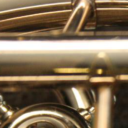

In [36]:
img.crop((60,60,320,320)).resize((128,128), resample=PIL.Image.BILINEAR)

It's a little bit slower but still fast enough for our purpose, so we will use this. We then define a general crop transform and two subclasses: `one to crop at the center (for validation) and one to randomly crop`. Each time, the subclass only implements the way to get the four corners passed to PIL.

In [37]:
# export
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz) == 2 else (sz[0], sz[0]))

def default_crop_size(w,h): return [w,w] if w < h else [h,h]

In [38]:
# export
class GeneralCrop(PilTransform):
    
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR):
        
        self.resample, self.size = resample, process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self,w,h): return default_crop_size(w,h)
        
    def __call__(self,x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(w,h):
        return (0,0,w,h)

In [39]:
# export
class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [40]:
il1.tfms = [MakeRGB(), CenterCrop(128), to_byte_tensor, to_float_tensor]

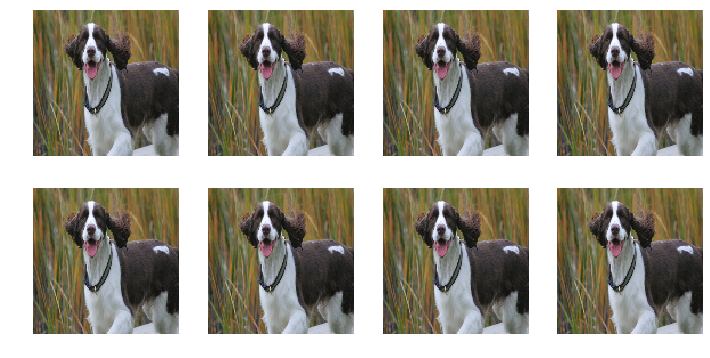

In [41]:
show_batch(next(iter(dl)))

This is the usual data augmentation used on ImageNet (introduced [here](https://arxiv.org/pdf/1409.4842.pdf)) that consists of selecting 8 to 100% of the image area and a scale between 3/4 and 4/3 as a crop, then resizing it to the desired size. It combines some zoom and a bit of squishing at a very low computational cost.

In [42]:
# export
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio
    
    def get_corners(self, w, h, wc, hc):
        area = w*h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # Fallback to central crop
        left,top = randint(0,w-self.crop_size[0]),randint(0,h-self.crop_size[1])
        return (left, top, left+self.crop_size[0], top+self.crop_size[1])
        # Fallback to central crop

In [43]:
il1.tfms = [MakeRGB(), RandomResizedCrop(128), to_byte_tensor, to_float_tensor]

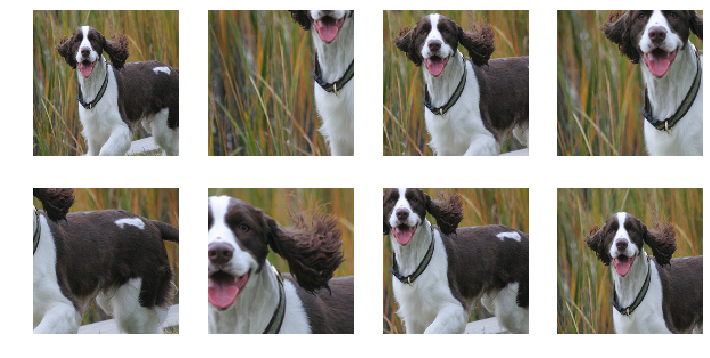

In [44]:
show_batch(next(iter(dl)))

In [45]:
!python3 notebook2script.py 08c_augmentation.ipynb

Converted 08c_augmentation.ipynb to lib/nb_08c.py
